# Comparing Decision Tree Against Random Forest with FIFA
Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

To begin, choose a dataset, build the best decision tree you can, then try to match that with the simplest random forest you can. For our purposes measure simplicity with [runtime]('https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution'). Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

This dataset, entitled [FIFA 19 Complete Player Dataset]('https://www.kaggle.com/karangadiya/fifa19'), was taken from Kaggle. In this model comparison, in order to observe the categorical expression in Classifiers, we will use the target variable of player's dominant foot (to have a little fun) and observe the benefits and drawbacks of decision trees and random forests.

In [1]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image

import pydotplus
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time

In [2]:
full_df = pd.read_csv('fifa19.csv')
df = full_df.drop(['Unnamed: 0','Photo','Flag','Club Logo','Real Face'],axis=1)
df.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
df.Value = df.Value.apply(lambda x: x.strip('€'))
df.Value = df.Value.replace(r'[KM]+$', '', regex=True).astype(float) * \
            df.Value.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)

df.Wage = df.Wage.apply(lambda x: x.strip('€'))
df.Wage = df.Wage.replace(r'[KM]+$', '', regex=True).astype(float) * \
            df.Wage.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)

df.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [4]:
types = pd.DataFrame(df.dtypes)
types[types != 'int64'].dropna()
text_names = list(types[types == 'object'].dropna().index)

In [5]:
#df = df.drop([[text_names]], axis=1)
features = df.drop(text_names, axis=1)
features = features.drop('Jersey Number', axis=1)
target = df['Preferred Foot']

features.isnull().sum()

empty_index = list(pd.isnull(features).any(1).nonzero()[0])
target = target.drop(empty_index)

features = features.dropna()
features.isnull().sum()

features.shape
target.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


(18159,)

### Decision Tree Classifier
After testing varieties of parameters *max_features* and *max_depth*, the most optimal conditions in terms of accuracy were set as follows:

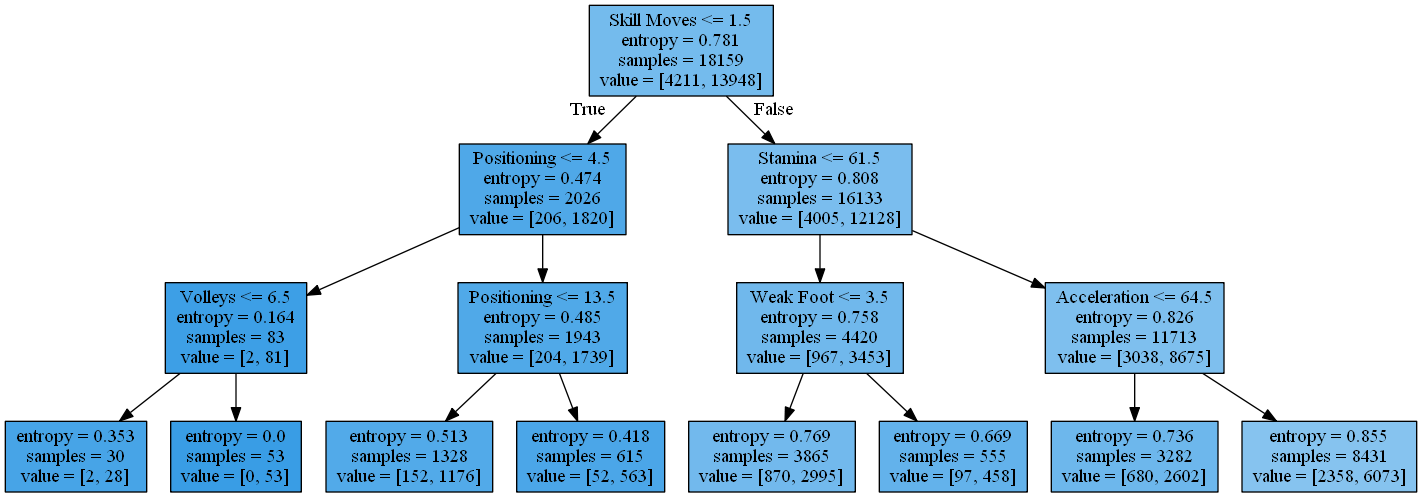

In [6]:
# Initialize and train our tree.
dtc = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3
)
dtc.fit(features, target)

# Render our tree.
dot_data = tree.export_graphviz(
    dtc, out_file=None,
    feature_names=features.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [7]:
print('Mean Accuracy of Decision Tree on Cross-Validation: ')

start_time = time.time()
tree_scores = cross_val_score(dtc, features, target, cv=10)
end_time = time.time()

print(tree_scores.mean())
print()

print("--- %s seconds ---" % (end_time - start_time))

Mean Accuracy of Decision Tree on Cross-Validation: 
0.7681039834315747

--- 0.34006762504577637 seconds ---


### Random Forest Classifier
##### Random Forest Model Closely Resembling Default Parameters

In [8]:
rfc = ensemble.RandomForestClassifier(
    n_estimators=10,
    criterion='entropy',
)

In [9]:
print('Mean Accuracy of Random Forest on Cross-Validation: ')

start_time = time.time()
forest_scores = cross_val_score(rfc, features, target, cv=10)
end_time = time.time()

print(forest_scores.mean())
print()

print("--- %s seconds ---" % (end_time - start_time))

Mean Accuracy of Random Forest on Cross-Validation: 
0.7243802393094692

--- 5.385197401046753 seconds ---


##### Random Forest Model Tuned to Run at Roughly the Same Speed as the Single Decision Tree

In [10]:
rfc_speedy = ensemble.RandomForestClassifier(
    n_estimators=2,
    max_depth=3,
    criterion='entropy',
)

In [11]:
print('Mean Accuracy of Random Forest on Cross-Validation: ')

start_time = time.time()
forest_scores = cross_val_score(rfc_speedy, features, target, cv=10)
end_time = time.time()

print(forest_scores.mean())
print()

print("--- %s seconds ---" % (end_time - start_time))

Mean Accuracy of Random Forest on Cross-Validation: 
0.7681039834315747

--- 0.48945116996765137 seconds ---


Each model needs to be tuned to its dataset, and this is very evident in the accuracy distinctions between the last two random forest models. The second random forest model had limiting parameters (that closely resembled the original decision tree) but still managed to perform better than the default parameter random forest - not to mention, it was significantly faster.

However, if one were to scale this to a larger dataset, the cost of running a default-parameter random forest model may not be worth the return. Because the Random Forest doesn't merely rely on a single decision tree, there is greater confidence in the model because of its variety; however, this requires more time and computing power that might be better suited in developing a different model and approach.

That being said, when doing supervised learning and while the size of the dataset and outcome are accounted for, the Random Forest classifier is a strong contender and, at leaset in this example, can predict with comparable accuracy (and greater confidence) than a single decision tree model.